In [1]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(12,10))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import datetime as dt

importing qubicpack without pystudio


There are two datasets to be anayzed:
- *linearityA* : offset is always 1V and we go from 0.5V to 2V amplitude. In this dataset the modulation does not always reach zero amplitude for the source.
- *linearityB* : Amplitude is always 2xOffset so that the modulation always goes from 0 to Amplitude 

In the following cell we read the corresponding filenames and order them, detect the offstes, amplitudes and modulation frequencies. We order the files by the amplitude of the modulation.

In [81]:
day = '2019-03-01'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.array(glob.glob(data_dir+'/*LinearityA*'))
dirs.sort()

#if day=='2019-02-28':
#    dirs = dirs[0:-1]

print dirs
print ''
labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
labels = np.array(labels)

modfreqs = np.zeros(len(labels))
amps = np.zeros(len(labels))
offsets = np.zeros(len(labels))
for i in xrange(len(labels)):
    bla = str.split(labels[i],'_')
    modfreqs[i] = np.float(bla[2][0:len(bla[2])-2])
    amps[i] = np.float(bla[4])
    offsets[i] = np.float(bla[6])

    
order = np.argsort(amps)
modfreqs = modfreqs[order]
amps = amps[order]
offsets = offsets[order]
labels = labels[order]
dirs = dirs[order]
print ''
print(dirs)
print ''
print labels
print(amps)
print(offsets)
print(modfreqs)

['/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.50.46__LinearityA_sin_0.333Hz_amp_3.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500']


['/qubi

And there are source data associated, that are read below. It contains time (computer-time from the rasberry pi) and amplitude of the power-meter. We read them all for this day and concatenate them. Later we'll pick the common period corresponding to each data file.

['/qubic/Data/Calib-TD/calsource/calsource_20190301T133531.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T133828.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134131.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134435.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134754.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135053.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135340.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135631.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135925.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T140226.dat']


(0, 200)

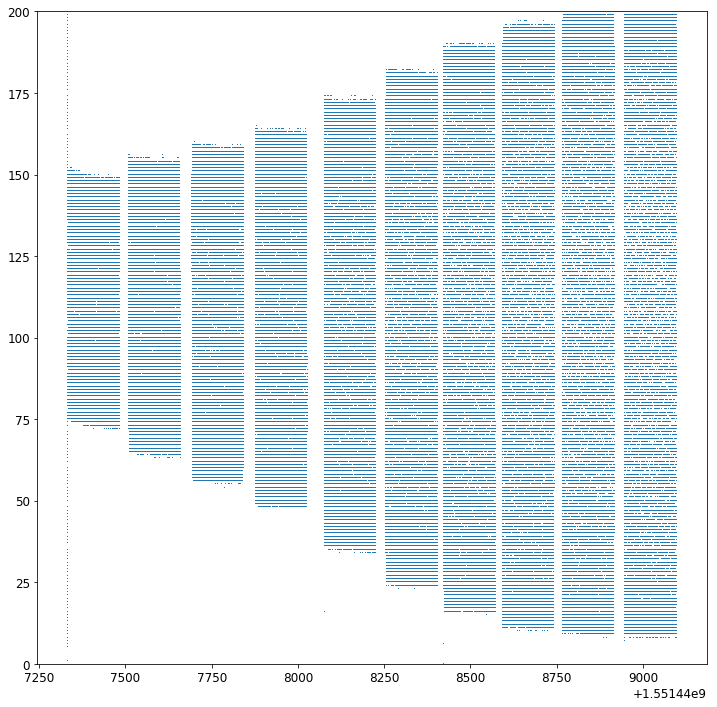

In [136]:
### The date format for calsrc has no '-' so we need to change the day to this very format.
daycalsrc = "".join(str.split(day,'-'))
fcalsrc = glob.glob('/qubic/Data/Calib-TD/calsource/*'+daycalsrc+'*')
fcalsrc.sort()
print fcalsrc

ttsrc = []
ddsrc = []
for ff in fcalsrc:
    thett, thedd = np.loadtxt(ff).T
    ttsrc.append(thett+3600)
    ddsrc.append(thedd)
    
ttsrc = np.concatenate(ttsrc)
ddsrc = np.concatenate(ddsrc)
plot(ttsrc,ddsrc,',')
ylim(0,200)

Now we read the data, then we find the common time between data and calsrc, then we put this into lists for each of the file.

In [137]:
tt = []
dd = []
mm = []
tt_src = []
dd_src = []
temperatures = []
for thedir in dirs:
    print ''
    print(thedir)
    a = qp()
    asicnum = 1
    a.read_qubicstudio_dataset(thedir, asic=asicnum)
    temperatures.append(a.temperature)
    nsamples = len(a.timeline(TES=96))
    pow2 = int(np.log(nsamples)/np.log(2))
    ns = 2**pow2
    FREQ_SAMPLING = 1./a.sample_period()

    #### Old version: no PPS, data timeline is just a linspace
    t_data = a.timeline_timeaxis(axistype='index')
    t0 = a.timeline_timeaxis(axistype='pps')[0]
    t_data = t_data + t0
    #### NEW version with PPS accounted for
#     t_data = a.timeline_timeaxis(axistype='pps')
#     t0 = t_data[0]
    import datetime as dt
    print('')
    print('DAta TIME:')
    print(thedir)
    print(dt.datetime.fromtimestamp(np.min(t_data)))
    print(dt.datetime.fromtimestamp(np.max(t_data)))
    print('SRC TIME:')
    print dt.datetime.fromtimestamp(np.min(ttsrc))
    print dt.datetime.fromtimestamp(np.max(ttsrc))
    
    TESnum = 96
    data = a.timeline(TES=TESnum)


#     print t_data[0:10]-t0
#     print ttsrc[0:10]-t0
#     plot(t_data-t0, data, ',')
#     plot(ttsrc-t0, ddsrc*1000)

    ### Find the region where there is source data
    oksrc = (ttsrc >= (t_data[0])) & (ttsrc <=(t_data[-1]))
    print 'Number of common points: {}'.format(oksrc.sum())
    thettsrc = ttsrc[oksrc]
    theddsrc = ddsrc[oksrc]
    
    
    ### now reduce each to matching regions
    print [np.min(t_data), np.min(thettsrc)]
    mini = np.max([np.min(t_data), np.min(thettsrc)])
    maxi = np.min([np.max(t_data), np.max(thettsrc)])
    okdata = (t_data >= mini) & (t_data <= maxi)
    oksrc = (thettsrc >= mini) & (thettsrc <= maxi)
    t_data = t_data[okdata]
    data = data[okdata]
    thettsrc = thettsrc[oksrc]
    theddsrc = theddsrc[oksrc]
        
    tt.append(t_data-t0)
    dd.append(data)
    mm.append(np.mean(data))
    tt_src.append(thettsrc-t0)
    dd_src.append(theddsrc)



/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.2

mean separation between pulses is 1.00 second
setting pps interval to 1 second

DAta TIME:
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500
2019-03-01 14:44:36.826923
2019-03-01 14:47:10.625323
SRC TIME:
2019-03-01 14:35:31.774819
2019-03-01 15:04:56.246846
Number of common points: 31731
[1551447876.8269231, 1551447876.830882]

/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic1-2019.03.01.144748.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic1-2019.03.01.144748.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks
reading f

setting pps interval to 0 second

DAta TIME:
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500
2019-03-01 14:56:34
2019-03-01 14:59:09.328000
SRC TIME:
2019-03-01 14:35:31.774819
2019-03-01 15:04:56.246846
Number of common points: 31875
[1551448594.0, 1551448594.002886]

/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Sums/science-asic1-2019.03.01.145919.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Sums/science-asic1-2019.03.01.145919.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.

Next cell displays the power-spectra of the data and calsrc. Beware that CalSrc is not evenly sampled so it's mandatory to resample it on a regular grid before taking the FFT.

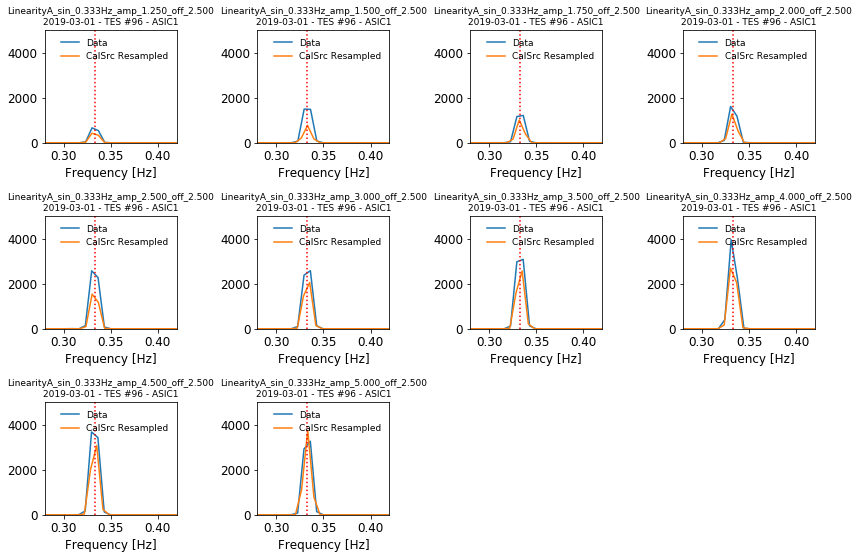

In [138]:
rc('figure',figsize=(12,10))
npl = int(np.sqrt(len(tt)))+1
fdata=0.0001
fsrc=0.0001
for ii in xrange(len(dd_src)):
    subplot(npl,npl,ii+1)
#     spectrum_src, freq_src = mlab.psd(dd_src[ii], Fs=1./np.mean(tt_src[0][1:]-tt_src[0][:-1]), 
#                                       NFFT=len(tt_src[ii]), window=mlab.window_hanning)
    spectrum, freq = mlab.psd(dd[ii], Fs=FREQ_SAMPLING, NFFT=len(tt[ii]), window=mlab.window_hanning)
    
    ## Resampling calsrc data
    newtime_src = np.arange(len(dd_src[ii]))*np.mean(tt_src[0][1:]-tt_src[0][:-1])
    newdata_src = np.interp(newtime_src, tt_src[ii], dd_src[ii])
    spectrum_src2, freq_src2 = mlab.psd(newdata_src, Fs=1./np.mean(tt_src[0][1:]-tt_src[0][:-1]), 
                                        NFFT=len(tt_src[ii]), window=mlab.window_hanning)
    
    plot(freq, f.gaussian_filter1d(spectrum,fdata)/np.mean(spectrum), label='Data')
    #plot(freq_src, f.gaussian_filter1d(spectrum_src,fsrc)/np.mean(spectrum_src), label='CalSrc')
    plot(freq_src2, f.gaussian_filter1d(spectrum_src2,fsrc)/np.mean(spectrum_src2), label='CalSrc Resampled')
    legend(fontsize=9,frameon=False)
    xlim(0.28,0.42)
    ylim(0,5000)
    xlabel('Frequency [Hz]')
    plot([0.333,0.333],[0,5000],'r:')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(TESnum, asicnum),fontsize=9)

tight_layout()

Below is how to model the source signal (Code by D. Mennella). We first read the data file and use it as a global variable (in order not to have to read at each fit iteration which would slow down the fitting very significantly), then construct a function for the sine input modulation modulated with this efficiency law: the sinesat function. It has 6 parameters, the two first are realted to the instrument:
- The amplitude of the QUBIC measured signal in ADU of the instrument
- The offset of the QUBCI measured signal in ADU of the instrument

and the 4 others are related to the source (and kept fixed during fitting):
- the voltage amplitude of the modulation of the source
- the period modulation of the source (in sec)
- the phase (in radians) of the modualtion
- the offset in V of the modulation

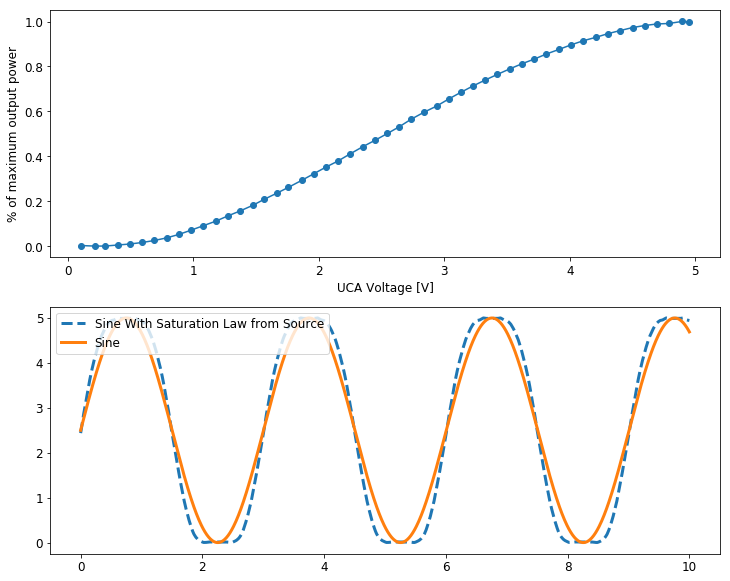

In [140]:
freq=150.
folder = '/qubic/Data/Calib-TD/calsource'
calibration_file = '%s/source_calibration_curve_%sGHz.txt' % (folder,int(freq))
data_calib = np.transpose(np.loadtxt(calibration_file))
subplot(2,1,1)
plot(data_calib[0,:], data_calib[1,:], 'o-')
xlabel('UCA Voltage [V]')
ylabel('% of maximum output power')

def source_cal(Vin, freq = 150., folder = '/qubic/Data/Calib-TD/calsource'):
    import scipy as sc

    '''
    This function interpolates the source calibration curve and returns an interpolated value at any point

    INPUTS
    Vin    - FLOAT - the input voltage [V]
    freq   - FLOAT - the RF frequency (default = 150 GHz)
    folder - STRING - the folder containing the calibration curve

    OUTPUTS
    result  - FLOAT - the interpolated value at Vin

    '''

    #calibration_file = '%s/source_calibration_curve_%sGHz.txt' % (folder,int(freq))
    #data = np.transpose(np.loadtxt(calibration_file))
    data = data_calib.copy()
    if Vin <= data[0][0]:
        out = data[1][0]
    elif Vin >= data[0][-1]:
        out = data[1][-1]
    else:
        fint = sc.interpolate.interp1d(data[0],data[1])
        out = fint(Vin)
    return out



def sim_generator_power(time, amplitude, offset, frequency, phase, 
rf_freq = 150.):

    '''
    This function simulates the power output of the source
    taking into account the source calibration curve

    INPUTS
    time      - FLOAT - the current time [s]
    amplitude - FLOAT - the p2p amplitude of the signal in the UCA stage of the generator [V]
    offset    - FLOAT - the offset of the signal in the UCA stage of the generator [V]
    frequency - FLOAT - the modulation frequency [Hz]
    phase     - FLOAT - the wave initial phase
    rf_freq   - FLOAT - the RF frequency (chosen to select the right calibration curve, defaults to 150 GHz)

    OUTPUTS
    uncal_signal, cal_signal  - FLOAT - the uncalibrated signal and the calibrated signal
                                     (percentage of max output power)interpolated value at Vin

    '''

    if type(time) == float:
        tim = np.array([time])
    else:
        tim = time
    sine = amplitude/2. * np.sin(2.*np.pi * frequency * tim + phase) # Divide by 2 because we provide the p2p
    uncal_signal = sine + offset
    cal_signal = np.array([source_cal(i) for i in uncal_signal])
    return cal_signal

def sine(x,pars):
    return 0.5*np.sqrt(pars[0]**2)*np.sin(2*np.pi*(x-pars[2])/pars[1])+pars[3]

def shift_src(x, pars):
    per=1./0.333
    return np.abs(pars[0])*np.interp(x, x-pars[2], allfolded_src[ii,:], period=per)+pars[1]

def sinesat_init(x,pars):
    return sim_generator_power(x, pars[0], pars[3], 1./pars[1], pars[2])

def sinesat(x,pars):
    return np.abs(pars[0])*sim_generator_power(x, pars[2], pars[5], 1./pars[3], pars[4])+pars[1]

subplot(2,1,2)
ttt = np.linspace(0,10,1000)
plot(ttt, sinesat(ttt, [5.,0., 5., 1./0.333,0., 2.5]),'--', lw=3,label='Sine With Saturation Law from Source')
plot(ttt, sine(ttt, [5., 1./0.333,0., 2.5]), lw=3,label='Sine')
legend(loc='upper left')

We now fold the data and the CalSrc over one period, then fit a sinewave on the folded data.

# NB: we reverse signs for the data here in order to have positive signal when the source is up.

In [141]:
reload(ft)
nbins = 150
allfolded = np.zeros((len(tt), nbins))
allfolded_src = np.zeros((len(tt), nbins))
allresfit = np.zeros((len(tt), 4))
allerrfit = np.zeros((len(tt), 4))
allresfit_src = np.zeros((len(tt), 3))
allerrfit_src = np.zeros((len(tt), 3))
allresfit_src_model = np.zeros((len(tt), 6))
allerrfit_src_model = np.zeros((len(tt), 6))
allres = []
for ii in xrange(len(tt)):
    ##### Folding data
    ns = len(tt[ii])
    #modulation_frequency = modfreqs[ii]
    modulation_frequency = 0.333
    folded, t, folded_nonorm, dy = ft.fold_data(tt[ii], -np.reshape(dd[ii], (1,ns)), 
                                            1./modulation_frequency, 0.01, 100., nbins, notch=None, return_error=True)
    allfolded[ii,:] = folded_nonorm
    ##### Fitting folded data with a sine
    guess = np.array([5000.*amps[ii], 1./modulation_frequency, 1.,0.])
    res = ft.do_minuit(t,allfolded[ii,:],dy, 
                       guess, functname=sine, fixpars=[0,1,0,0],verbose=False, force_chi2_ndf=True)
    allresfit[ii,:] = res[1]
    allerrfit[ii,:] = res[2]

    ##### Folding Source data
    folded_src, tsrc, folded_nonorm_src, dy_src = ft.fold_data(tt_src[ii], np.reshape(dd_src[ii], (1,len(dd_src[ii]))), 
                                            1./modulation_frequency, 0.01, 100., nbins, notch=None, return_error=True)
    allfolded_src[ii,:] = folded_nonorm_src

    ##### Fitting a possible shift in t and y to source data
    guess = np.array([600, 0.1,100])
    res = ft.do_minuit(t,allfolded[ii,:],dy, 
                        guess, functname=shift_src, fixpars=[0,0,0],verbose=False, force_chi2_ndf=True, nohesse=True)
    allresfit_src[ii,:] = res[1]
    allerrfit_src[ii,:] = res[2]    
    
    ##### Fitting The model source data
    guess = np.array([600, np.mean(allfolded[ii,:]),  amps[ii], 1./modfreqs[ii],np.mean(t), offsets[ii]])
    res = ft.do_minuit(t,allfolded[ii,:],dy, 
                        guess, functname=sinesat, fixpars=[0,0,1,1,0,1],verbose=False, force_chi2_ndf=True, nohesse=True)
    allresfit_src_model[ii,:] = res[1]
    allerrfit_src_model[ii,:] = res[2]

Detectors 100%[==================================================]Time: 0:00:00


FCN = 86.9420097505 
 TOTAL NCALL = 54 
 NCALLS = 54 
 
 
 EDM = 0.000100153694303 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,49168.7,321.89,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,1.01899,0.0030804,0,0,,,
4,c3,5.05832,113.057,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,49168.7,321.89,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,1.01899,0.0030804,0,0,,,
4,c3,5.05832,113.057,0,0,,,


+,c0,c2,c3
c0,1.00,-0.01,0.04
c2,-0.01,1.00,-0.06
c3,0.04,-0.06,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 75.8560822586 
 TOTAL NCALL = 68 
 NCALLS = 68 
 
 
 EDM = 2.8130874101e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,659.14,4.3138,0,0,,,
2,c1,-3.36452,112.981,0,0,,,
3,c2,101.238,0.00267793,0,0,,,


FCN = 96.1663124492 
 TOTAL NCALL = 112 
 NCALLS = 112 
 
 
 EDM = 2.8628006094e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,126988,831.454,0,0,,,
2,c1,-62113.4,418.193,0,0,,,
3,c2,1.25,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,4.15084,0.00644131,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 165.665183617 
 TOTAL NCALL = 77 
 NCALLS = 77 
 
 
 EDM = 4.67888816711e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,59591,297.972,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,2.27271,0.0023675,0,0,,,
4,c3,6.40834,104.866,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,59591,297.972,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,2.27271,0.0023675,0,0,,,
4,c3,6.40834,104.866,0,0,,,


+,c0,c2,c3
c0,1.00,-0.01,0.02
c2,-0.01,1.00,0.02
c3,0.02,0.02,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 148.876208456 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = 4.69478483128e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,696.018,3.47944,0,0,,,
2,c1,9.81097,104.868,0,0,,,
3,c2,101.233,0.0021292,0,0,,,


FCN = 173.569310976 
 TOTAL NCALL = 101 
 NCALLS = 101 
 
 
 EDM = 1.01172334375e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128909,644.645,0,0,,,
2,c1,-63060.5,330.373,0,0,,,
3,c2,1.5,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,1.52797,0.00493892,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 166.342682552 
 TOTAL NCALL = 69 
 NCALLS = 69 
 
 
 EDM = 2.9092180543e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,69718.3,344.844,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.823827,0.00233382,0,0,,,
4,c3,31.9801,121.297,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,69718.3,344.844,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.823827,0.00233382,0,0,,,
4,c3,31.9801,121.297,0,0,,,


+,c0,c2,c3
c0,1.00,0.01,0.05
c2,0.01,1.00,0.05
c3,0.05,0.05,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 136.648238711 
 TOTAL NCALL = 66 
 NCALLS = 66 
 
 
 EDM = 9.05689871791e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,684.654,3.38605,0,0,,,
2,c1,26.708,121.278,0,0,,,
3,c2,101.259,0.00217243,0,0,,,


FCN = 166.561836123 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 7.02243784277e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,130575,645.846,0,0,,,
2,c1,-63834.9,332.202,0,0,,,
3,c2,1.75,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,4.55901,0.0048594,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 272.843138322 
 TOTAL NCALL = 76 
 NCALLS = 76 
 
 
 EDM = 1.52306536805e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,77589.7,405.456,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.148712,0.00250145,0,0,,,
4,c3,-9.12319,143.46,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,77589.7,405.456,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.148712,0.00250145,0,0,,,
4,c3,-9.12319,143.46,0,0,,,


+,c0,c2,c3
c0,1.00,0.01,-0.01
c2,0.01,1.00,0.01
c3,-0.01,0.01,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 223.086251289 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = 2.3444520743e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,684.196,3.57289,0,0,,,
2,c1,3.003,143.46,0,0,,,
3,c2,101.232,0.00237694,0,0,,,


FCN = 253.238292943 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 6.83781177041e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128673,672.219,0,0,,,
2,c1,-62876.1,359.34,0,0,,,
3,c2,2,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,-0.311276,0.00520568,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 1409.71637053 
 TOTAL NCALL = 54 
 NCALLS = 54 
 
 
 EDM = 1.7046523248e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,94772.4,238.628,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,1.03105,0.00121397,0,0,,,
4,c3,-67.1165,84.7376,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,94772.4,238.628,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,1.03105,0.00121397,0,0,,,
4,c3,-67.1165,84.7376,0,0,,,


+,c0,c2,c3
c0,1.00,0.00,0.00
c2,0.00,1.00,0.01
c3,0.00,0.01,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 923.128724568 
 TOTAL NCALL = 69 
 NCALLS = 69 
 
 
 EDM = 6.60445300983e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,683.764,1.71899,0,0,,,
2,c1,-42.298,84.7379,0,0,,,
3,c2,101.247,0.0011562,0,0,,,


FCN = 1093.39579827 
 TOTAL NCALL = 89 
 NCALLS = 89 
 
 
 EDM = 1.11260170949e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,129565,327.192,0,0,,,
2,c1,-63194,179.495,0,0,,,
3,c2,2.5,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,4.1256,0.00253149,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 1053.90362774 
 TOTAL NCALL = 68 
 NCALLS = 68 
 
 
 EDM = 3.4329424053e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,109062,318.352,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,-0.139751,0.00140142,0,0,,,
4,c3,-16.0834,112.801,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,109062,318.352,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,-0.139751,0.00140142,0,0,,,
4,c3,-16.0834,112.801,0,0,,,


+,c0,c2,c3
c0,1.00,0.02,0.00
c2,0.02,1.00,-0.01
c3,0.00,-0.01,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 535.241906419 
 TOTAL NCALL = 69 
 NCALLS = 69 
 
 
 EDM = 4.66625545434e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,687.402,2.00192,0,0,,,
2,c1,-12.5645,112.797,0,0,,,
3,c2,101.248,0.00133952,0,0,,,


FCN = 620.611432888 
 TOTAL NCALL = 319 
 NCALLS = 319 
 
 
 EDM = 0.00852207489294 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128470,377.871,0,0,,,
2,c1,-62547.7,215.833,0,0,,,
3,c2,3,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,-5.38736e+07,0.0148927,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 1856.1752593 
 TOTAL NCALL = 79 
 NCALLS = 79 
 
 
 EDM = 3.1320825117e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,122096,266.345,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,-0.457663,0.00100816,0,0,,,
4,c3,92.9654,92.6944,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,122096,266.345,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,-0.457663,0.00100816,0,0,,,
4,c3,92.9654,92.6944,0,0,,,


+,c0,c2,c3
c0,1.00,0.00,0.04
c2,0.00,1.00,0.06
c3,0.04,0.06,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 632.413573054 
 TOTAL NCALL = 76 
 NCALLS = 76 
 
 
 EDM = 3.27409231596e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,686.376,1.4931,0,0,,,
2,c1,87.4918,92.6848,0,0,,,
3,c2,101.264,0.000962412,0,0,,,


FCN = 739.349980043 
 TOTAL NCALL = 84 
 NCALLS = 84 
 
 
 EDM = 1.53080415967e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,127992,277.524,0,0,,,
2,c1,-62132.4,160.867,0,0,,,
3,c2,3.5,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,0.956913,0.00205077,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 1608.23671091 
 TOTAL NCALL = 73 
 NCALLS = 73 
 
 
 EDM = 7.24079909406e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,129397,315.679,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.629403,0.00117053,0,0,,,
4,c3,90.1342,111.953,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,129397,315.679,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.629403,0.00117053,0,0,,,
4,c3,90.1342,111.953,0,0,,,


+,c0,c2,c3
c0,1.00,-0.00,-0.03
c2,-0.00,1.00,0.06
c3,-0.03,0.06,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 367.234896493 
 TOTAL NCALL = 55 
 NCALLS = 55 
 
 
 EDM = 4.13212788272e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,665.522,1.64186,0,0,,,
2,c1,-18.1918,111.967,0,0,,,
3,c2,100.582,0.00112381,0,0,,,


FCN = 387.833260118 
 TOTAL NCALL = 99 
 NCALLS = 99 
 
 
 EDM = 3.2033059377e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,125013,303.889,0,0,,,
2,c1,-60951.1,188.941,0,0,,,
3,c2,4,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,-1.31591,0.00238253,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 2625.36048678 
 TOTAL NCALL = 74 
 NCALLS = 74 
 
 
 EDM = 2.46751542878e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,135439,298.303,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.544277,0.00103173,0,0,,,
4,c3,126.732,104.701,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,135439,298.424,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,0.544277,0.00103056,0,0,,,
4,c3,126.732,104.688,0,0,,,


+,c0,c2,c3
c0,1.00,0.01,0.10
c2,0.01,1.00,-0.06
c3,0.10,-0.06,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 713.530795333 
 TOTAL NCALL = 67 
 NCALLS = 67 
 
 
 EDM = 5.41621032776e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,650.707,1.42721,0,0,,,
2,c1,78.1361,104.629,0,0,,,
3,c2,101.256,0.000962676,0,0,,,


FCN = 609.286293758 
 TOTAL NCALL = 85 
 NCALLS = 85 
 
 
 EDM = 4.85528913166e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,123267,270.574,0,0,,,
2,c1,-60248.8,160.866,0,0,,,
3,c2,4.5,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,-1.1406,0.00219631,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Detectors 100%[==================================================]Time: 0:00:00


FCN = 3592.46401533 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = 5.3855557708e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,139450,294.206,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,1.50633,0.00100565,0,0,,,
4,c3,-84.5474,104.131,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,139450,296.064,0,0,,,
2,c1,3.003,1,0,0,,,FIXED
3,c2,1.50633,0.00100665,0,0,,,
4,c3,-84.5474,104.341,0,0,,,


+,c0,c2,c3
c0,1.00,0.02,0.06
c2,0.02,1.00,-0.00
c3,0.06,-0.00,1.00


Detectors 100%[==================================================]Time: 0:00:00


FCN = 566.885930656 
 TOTAL NCALL = 66 
 NCALLS = 66 
 
 
 EDM = 1.86017548858e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,644.315,1.35884,0,0,,,
2,c1,18.2587,104.353,0,0,,,
3,c2,101.238,0.00093235,0,0,,,


FCN = 484.605996818 
 TOTAL NCALL = 150 
 NCALLS = 150 
 
 
 EDM = 4.32282696462e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,-122120,257.432,0,0,,,
2,c1,-60014.5,158.819,0,0,,,
3,c2,5,1,0,0,,,FIXED
4,c3,3.003,1,0,0,,,FIXED
5,c4,97.3792,0.00137395,0,0,,,
6,c5,2.5,1,0,0,,,FIXED


Next cell is just a plot of the previous calculations. Normally one sees the saturation effect on the calsrc and the data for some of the files.

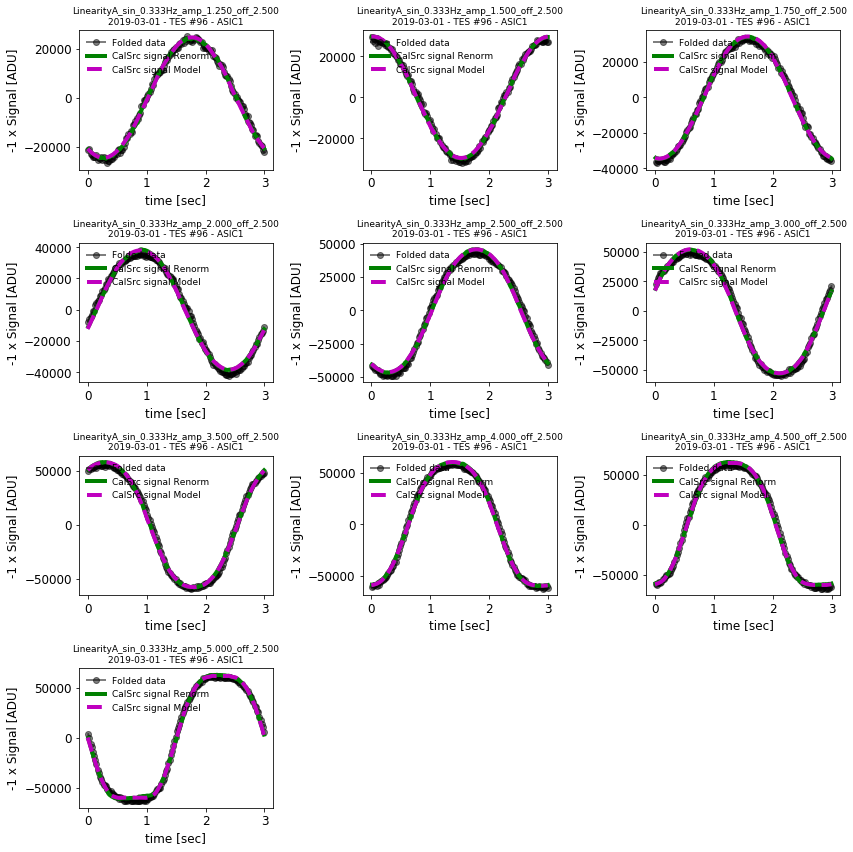

In [142]:
#### npl = int(np.sqrt(len(tt)))+1
rc('figure',figsize=(12,12))
ttt = np.linspace(0,np.max(t),1000)
for ii in xrange(len(tt)):
    subplot(4,3,ii+1)
    p=plot(t,allfolded[ii,:],'ko-', lw=2, alpha=0.5,label='Folded data')
#     plot(ttt, sine(ttt, allresfit[ii,:]),'r--', lw=2, 
#            label='AmpFit={0:6.1f} \nPeriodFit={1:6.1f} \nPhaseFit={2:6.1f}'.format(allresfit[ii,0],
#                                                                                    allresfit[ii,1],allresfit[ii,2]))
    p=plot(tsrc, shift_src(tsrc, allresfit_src[ii,:]),'g-', lw=4, label='CalSrc signal Renorm')
    p=plot(ttt, sinesat(ttt, allresfit_src_model[ii,:]),'m--', lw=4, label='CalSrc signal Model')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(TESnum, asicnum),fontsize=9)
    xlabel('time [sec]')
    ylabel('-1 x Signal [ADU]')
    legend(fontsize=9,frameon=False, loc='upper left')
tight_layout()

Now accounting for the intrinsic saturation of the source (code by Daniele Mennella)

Here we plot the amplitude of the fitted sinewave as a function of the input modulation. The saturation effect might be seen for large modulation amplitude.

(array([ 49168.67787439,  59591.0286351 ,  69718.34053279,  77589.6605107 ,
        94772.42058699, 109062.21570903, 122096.42633222, 129397.02291076,
       135439.21411168, 139450.08909677]), array([ 248.39705168,  317.40547412,  368.08478042,  554.27254968,
        741.49879545,  855.326856  ,  949.68180679, 1047.71848044,
       1265.47183452, 1468.60603266]))
Fitting with Minuit


FCN = 36.213523594 
 TOTAL NCALL = 106 
 NCALLS = 106 
 
 
 EDM = 2.57952921388e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,141677,1131.99,0,0,,,
2,c1,1.81238,0.0181786,0,0,,,
3,c2,0.921713,0.016541,0,0,,,
4,c3,0,1,0,0,,,FIXED


correcting errorbars to have chi2/ndf=1 - correction = 36.213523594
[1.41677269e+05 1.81238323e+00 9.21713401e-01 0.00000000e+00]
[2.78100695e+03 4.46601983e-02 4.06369717e-02 0.00000000e+00]
('Chi2=', 36.21352359397458)
('ndf=', 6)
Fitting with Minuit


FCN = 0.0100981949464 
 TOTAL NCALL = 309 
 NCALLS = 309 
 
 
 EDM = 0.00019501677023 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,677.685,170.995,0,0,,,
2,c1,7.68032,148.438,0,0,,,
3,c2,-0.828464,33.8329,0,0,,,
4,c3,0,1,0,0,,,FIXED


correcting errorbars to have chi2/ndf=1 - correction = 0.0100981949464
[677.68508605   7.68032107  -0.82846363   0.        ]
[7.01503022 6.08961658 1.38798791 0.        ]
('Chi2=', 0.010098194946374955)
('ndf=', 6)
Fitting with Minuit


FCN = 79.4884450508 
 TOTAL NCALL = 216 
 NCALLS = 216 
 
 
 EDM = 2.38311592185e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128475,175.692,0,0,,,
2,c1,6.91353,0.442441,0,0,,,
3,c2,-0.690788,0.139597,0,0,,,
4,c3,0,1,0,0,,,FIXED


correcting errorbars to have chi2/ndf=1 - correction = 79.4884450508
[ 1.28474557e+05  6.91353104e+00 -6.90787722e-01  0.00000000e+00]
[6.39481356e+02 1.61039157e+00 5.08102271e-01 0.00000000e+00]
('Chi2=', 79.48844505076673)
('ndf=', 6)


Text(0,0.5,'Calib w.r.t. Model Input Src Signal')

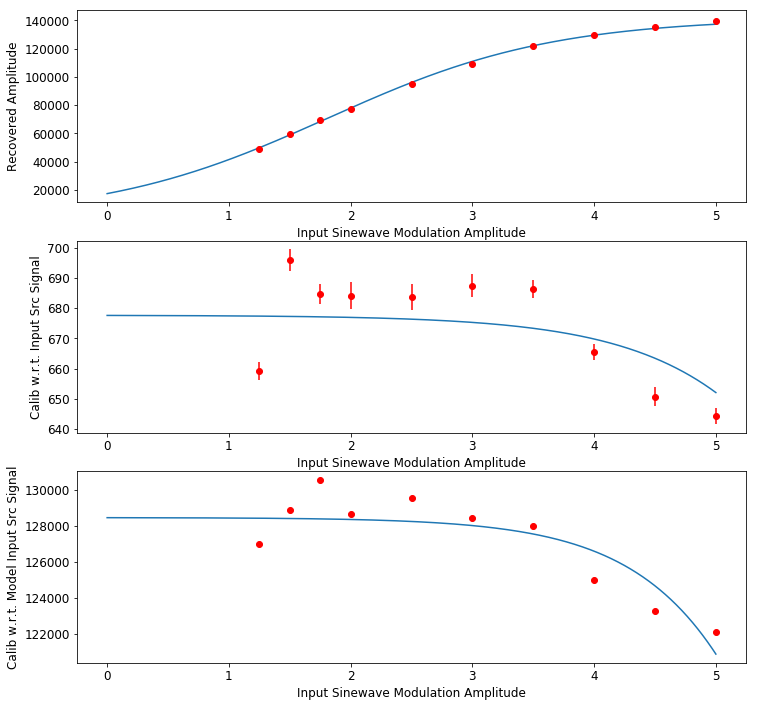

In [143]:
print(allresfit[:,0],allerrfit[:,0])
xxx = np.linspace(0,np.max(amps),1000)

def logistic(x,pars):
    return pars[3]+pars[0]*1./(1+np.exp(-(x-pars[1])/pars[2]))

subplot(3,1,1)
guess = np.array([np.max(allresfit[:,0]),1.,1.,0.])
res = ft.do_minuit(amps,np.abs(allresfit[:,0]),allerrfit[:,0], guess, 
                   fixpars=[0,0,0,1],
                   functname=logistic,verbose=True, force_chi2_ndf=True, nohesse=True)
errorbar(amps, np.abs(allresfit[:,0]), yerr=allerrfit[:,0], fmt='ro')
plot(xxx, logistic(xxx,res[1]))
xlabel('Input Sinewave Modulation Amplitude')
ylabel('Recovered Amplitude')

subplot(3,1,2)
guess = np.array([np.max(allresfit_src[:,0]),1.,-1.,0.])
res = ft.do_minuit(amps,np.abs(allresfit_src[:,0]),allerrfit[:,0], guess, 
                   fixpars=[0,0,0,1],
                   functname=logistic,verbose=True, force_chi2_ndf=True, nohesse=True)
errorbar(amps, allresfit_src[:,0], yerr=allerrfit_src[:,0], fmt='ro')
plot(xxx, logistic(xxx,res[1]))
xlabel('Input Sinewave Modulation Amplitude')
ylabel('Calib w.r.t. Input Src Signal')

subplot(3,1,3)
guess = np.array([np.max(allresfit_src_model[:,0]),1.,-1.,0.])
res = ft.do_minuit(amps,np.abs(allresfit_src_model[:,0]),allerrfit[:,0], guess, 
                   fixpars=[0,0,0,1],
                   functname=logistic,verbose=True, force_chi2_ndf=True, nohesse=True)
errorbar(amps, np.abs(allresfit_src_model[:,0]), yerr=allerrfit_src[:,0], fmt='ro')
plot(xxx, logistic(xxx,res[1]))
xlabel('Input Sinewave Modulation Amplitude')
ylabel('Calib w.r.t. Model Input Src Signal')


In fact what we want is to see the output of the TES as a function of the input power. So this is what we do in the next cell. The input power can be chosen form the input sinewave (that does not contain the intrinsic non-linearity of the source) or the calsrc data. Of course the latter is the relevant one.

We fit one Vs the other with a linear law (should surely be improved in the future).

The result makes sense when using the Sinewave fitted on the data: we see a clear saturation for the high values of the src.  But it is a mixture of that of the source and that of the TES. The result makes less sense (for now) if we take the CalSrc data Vs Data.

In [214]:
methods = ['Fitted Sinewave', 'CalSrc Signal', 'Model CalSrc Signal']
nbm = len(methods)

#### Linear fitting parameters
allres = np.zeros((nbm, 2,len(tt)))
allerr = np.zeros((nbm, 2,len(tt)))

#### Logistic fitting parameters
allres_logistic = np.zeros((nbm, 4,len(tt)))
allerr_logistic = np.zeros((nbm, 4,len(tt)))

for im in xrange(len(methods)):
    for ii in xrange(len(tt)):
        if methods[im]=='Fitted Sinewave':
            params = allresfit[ii,:]#np.array([amps[ii]/2, 1./modfreqs[ii], allresfit[ii,2],offsets[ii]])
            input_curve = sine(t, params)
        elif methods[im]=='CalSrc Signal':
            input_curve = shift_src(tsrc, allresfit_src[ii,:])/np.abs(allresfit_src[ii,0])
        elif methods[im] == 'Model CalSrc Signal':
            input_curve = sinesat(tsrc, allresfit_src_model[ii,:])/np.abs(allresfit_src_model[ii,0])+0.5

        ### Fitting with a straight line
        res = ft.do_minuit(input_curve, allfolded[ii,:],np.zeros(len(t))+1., 
                       np.array([0.,10000.]), functname=ft.thepolynomial,verbose=False, force_chi2_ndf=True)
        allres[im, :,ii] = res[1]
        allerr[im, :,ii] = res[2]

        ### Fitting with an efficiency curve
        if ii == 0:
            guess = np.array([np.max(allfolded[ii,:]),np.mean(input_curve),np.std(input_curve),np.min(allfolded[ii,:])])
        else:
            guess = res_logistic[1]
        res_logistic = ft.do_minuit(input_curve, allfolded[ii,:],np.zeros(len(t))+1., 
                       guess, functname=logistic,verbose=False, force_chi2_ndf=True, nohesse=True)
        allres_logistic[im, :,ii] = res_logistic[1]
        allerr_logistic[im, :,ii] = res_logistic[2]


FCN = 166450078.959 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 7.88639645282e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.999532,4.6969e-06,0,0,,,
2,c1,-5.01507,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.999532,4.6969e-06,0,0,,,
2,c1,-5.01507,0.0816497,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


FCN = 88479212.2649 
 TOTAL NCALL = 10006 
 NCALLS = 10006 
 
 
 EDM = 22.2772463961 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 True

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,4.49759e+06,1338.81,0,0,,,
2,c1,-473001,63.4607,0,0,,,
3,c2,138233,15.0434,0,0,,,
4,c3,-4.35435e+06,1336.59,0,0,,,


FCN = 271770880.369 
 TOTAL NCALL = 40 
 NCALLS = 40 
 
 
 EDM = 2.00363426165e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00008,3.87541e-06,0,0,,,
2,c1,-6.37861,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00008,3.87541e-06,0,0,,,
2,c1,-6.37861,0.0816497,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 92747849.4518 
 TOTAL NCALL = 155 
 NCALLS = 155 
 
 
 EDM = 4.12053608306e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,4.49621e+06,4.6168,0,0,,,
2,c1,-465598,22.3332,0,0,,,
3,c2,135054,9.37428,0,0,,,
4,c3,-4.356e+06,5.37183,0,0,,,


FCN = 368245973.658 
 TOTAL NCALL = 40 
 NCALLS = 40 
 
 
 EDM = 7.08596592735e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.997481,3.31247e-06,0,0,,,
2,c1,-31.9148,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.997481,3.31247e-06,0,0,,,
2,c1,-31.9148,0.0816497,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 87497576.1622 
 TOTAL NCALL = 226 
 NCALLS = 226 
 
 
 EDM = 7.49975558155e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,4.50203e+06,4.03422,0,0,,,
2,c1,-494516,18.8241,0,0,,,
3,c2,147158,8.22093,0,0,,,
4,c3,-4.34908e+06,4.74382,0,0,,,


FCN = 838843050.328 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 1.08113970101e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00164,2.97643e-06,0,0,,,
2,c1,8.93326,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00164,2.97643e-06,0,0,,,
2,c1,8.93326,0.0816497,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 103208965.614 
 TOTAL NCALL = 292 
 NCALLS = 292 
 
 
 EDM = 0.00885815069487 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,4.48699e+06,0.96195,0,0,,,
2,c1,-415968,0.762055,0,0,,,
3,c2,114797,0.28503,0,0,,,
4,c3,-4.36725e+06,0.960994,0,0,,,


FCN = 1508300664.28 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 2.07750321977e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00055,2.43679e-06,0,0,,,
2,c1,67.2396,0.0816498,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00055,2.43679e-06,0,0,,,
2,c1,67.2396,0.0816499,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 142884892.43 
 TOTAL NCALL = 2453 
 NCALLS = 2453 
 
 
 EDM = 1.10384848207e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,152749,4.58846,0,0,,,
2,c1,-18223.8,1.07128,0,0,,,
3,c2,31883.5,1.09031,0,0,,,
4,c3,-93231.6,3.38832,0,0,,,


FCN = 2014606552.23 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 6.37150155724e-13 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.999679,2.11751e-06,0,0,,,
2,c1,15.8293,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.999679,2.11751e-06,0,0,,,
2,c1,15.8293,0.0816497,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 183231116.504 
 TOTAL NCALL = 163 
 NCALLS = 163 
 
 
 EDM = 2.11928185731e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,141874,2.11971,0,0,,,
2,c1,-12057,0.462482,0,0,,,
3,c2,28527.8,0.590349,0,0,,,
4,c3,-81208.6,1.43784,0,0,,,


FCN = 2374783354.39 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 6.51336611797e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.996013,1.89146e-06,0,0,,,
2,c1,-92.7131,0.0816498,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.996013,1.89146e-06,0,0,,,
2,c1,-92.7131,0.0816499,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 248401141.24 
 TOTAL NCALL = 128 
 NCALLS = 128 
 
 
 EDM = 6.40208784615e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,144995,1.51848,0,0,,,
2,c1,-8279.66,0.328666,0,0,,,
3,c2,28501.1,0.460448,0,0,,,
4,c3,-79292.8,0.956656,0,0,,,


FCN = 3011116661.09 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 2.50033683238e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00128,1.78474e-06,0,0,,,
2,c1,-90.4107,0.0816498,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,1.00128,1.78474e-06,0,0,,,
2,c1,-90.4107,0.0816498,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 152364052.667 
 TOTAL NCALL = 124 
 NCALLS = 124 
 
 
 EDM = 0.000100793292075 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,143892,1.13067,0,0,,,
2,c1,-5818.61,0.264279,0,0,,,
3,c2,27004.2,0.360619,0,0,,,
4,c3,-76567.3,0.686326,0,0,,,


FCN = 4353593899.87 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 1.10120358087e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.996603,1.70512e-06,0,0,,,
2,c1,-126.523,0.0816499,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.996603,1.70512e-06,0,0,,,
2,c1,-126.523,0.0816499,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 237446399.491 
 TOTAL NCALL = 100 
 NCALLS = 100 
 
 
 EDM = 1.4742752262e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,141001,0.867472,0,0,,,
2,c1,-5252.81,0.226755,0,0,,,
3,c2,25191.9,0.291513,0,0,,,
4,c3,-74513.1,0.526392,0,0,,,


FCN = 5931523775.71 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 7.11776945203e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.997456,1.65608e-06,0,0,,,
2,c1,84.6908,0.0816498,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,0.997456,1.65608e-06,0,0,,,
2,c1,84.6908,0.0816498,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 281018526.934 
 TOTAL NCALL = 128 
 NCALLS = 128 
 
 
 EDM = 5.75603343945e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,137507,0.660298,0,0,,,
2,c1,-3276.82,0.194826,0,0,,,
3,c2,23130.3,0.233321,0,0,,,
4,c3,-71026.7,0.388764,0,0,,,


FCN = 146037748.595 
 TOTAL NCALL = 33 
 NCALLS = 33 
 
 
 EDM = 1.4449820209e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,658.891,0.00309549,0,0,,,
2,c1,3.27978,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,658.891,0.00309549,0,0,,,
2,c1,3.27978,0.0816497,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 101171469.519 
 TOTAL NCALL = 10005 
 NCALLS = 10005 
 
 
 EDM = 251.147058171 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 True

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.35011e+06,2003.16,0,0,,,
2,c1,-952.718,0.168284,0,0,,,
3,c2,270.986,0.0407917,0,0,,,
4,c3,-6.166e+06,1989.2,0,0,,,


FCN = 243435745.757 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 1.47160773691e-11 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,696.1,0.00269687,0,0,,,
2,c1,-8.93884,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,696.1,0.00269687,0,0,,,
2,c1,-8.93884,0.0816497,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 89969250.064 
 TOTAL NCALL = 450 
 NCALLS = 450 
 
 
 EDM = 2.270708584e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.33562e+06,0.98465,0,0,,,
2,c1,-785.594,0.00119583,0,0,,,
3,c2,211.139,0.000405298,0,0,,,
4,c3,-6.1844e+06,0.979615,0,0,,,


FCN = 295349464.262 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 2.92377391524e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,683.287,0.00226817,0,0,,,
2,c1,-27.5563,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,683.287,0.00226817,0,0,,,
2,c1,-27.5563,0.0816497,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 80690669.3268 
 TOTAL NCALL = 285 
 NCALLS = 285 
 
 
 EDM = 7.22279352891e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.34349e+06,0.984114,0,0,,,
2,c1,-863.033,0.00120223,0,0,,,
3,c2,238.914,0.00042621,0,0,,,
4,c3,-6.17506e+06,0.979063,0,0,,,


FCN = 687926511.065 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 9.5126816639e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,685.038,0.00203427,0,0,,,
2,c1,-3.63598,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,685.038,0.00203427,0,0,,,
2,c1,-3.63598,0.0816497,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 95694401.9584 
 TOTAL NCALL = 320 
 NCALLS = 320 
 
 
 EDM = 2.41996975954e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.32529e+06,0.959232,0,0,,,
2,c1,-711.303,0.00114696,0,0,,,
3,c2,182.601,0.000385957,0,0,,,
4,c3,-6.19634e+06,0.958053,0,0,,,


FCN = 989889528.917 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 1.14788623128e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,683.992,0.00166327,0,0,,,
2,c1,41.6749,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,683.992,0.00166327,0,0,,,
2,c1,41.6749,0.0816497,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 159243254.878 
 TOTAL NCALL = 221 
 NCALLS = 221 
 
 
 EDM = 0.00295748997376 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.33926e+06,0.963423,0,0,,,
2,c1,-826.364,0.00113671,0,0,,,
3,c2,224.261,0.000411989,0,0,,,
4,c3,-6.18052e+06,0.961975,0,0,,,


FCN = 1034910153.74 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 1.71558867799e-13 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,687.289,0.00145262,0,0,,,
2,c1,12.7854,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,687.289,0.00145262,0,0,,,
2,c1,12.7854,0.0816497,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 306833211.341 
 TOTAL NCALL = 280 
 NCALLS = 280 
 
 
 EDM = 0.0160711545315 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.36667e+06,0.979187,0,0,,,
2,c1,-1019.68,0.00113711,0,0,,,
3,c2,303.614,0.000457633,0,0,,,
4,c3,-6.1493e+06,0.975388,0,0,,,


FCN = 795543804.325 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 4.10754659996e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,684.991,0.00129713,0,0,,,
2,c1,-86.3517,0.0816498,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,684.991,0.00129713,0,0,,,
2,c1,-86.3517,0.0816498,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 347163101.707 
 TOTAL NCALL = 398 
 NCALLS = 398 
 
 
 EDM = 7.33444284933e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.41879e+06,6.93585,0,0,,,
2,c1,-1332.05,0.0354484,0,0,,,
3,c2,455.735,0.0194159,0,0,,,
4,c3,-6.08862e+06,7.84622,0,0,,,


FCN = 691413772.733 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 1.07382640576e-13 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,665.497,0.00118187,0,0,,,
2,c1,16.7584,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,665.497,0.00118187,0,0,,,
2,c1,16.7584,0.0816497,0,0,,,


+,c0,c1
c0,1.00,0.00
c1,0.00,1.00


FCN = 278616357.722 
 TOTAL NCALL = 341 
 NCALLS = 341 
 
 
 EDM = 0.0113326462819 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.43552e+06,1.0285,0,0,,,
2,c1,-1464.54,0.0012105,0,0,,,
3,c2,522.258,0.000582252,0,0,,,
4,c3,-6.06538e+06,1.01191,0,0,,,


FCN = 1155978289.46 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 6.78674493234e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,648.521,0.00110442,0,0,,,
2,c1,-80.2051,0.0816498,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,648.521,0.00110442,0,0,,,
2,c1,-80.2051,0.0816498,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 351888647.896 
 TOTAL NCALL = 406 
 NCALLS = 406 
 
 
 EDM = 0.0107699884217 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.39516e+06,0.990222,0,0,,,
2,c1,-1269.43,0.00118479,0,0,,,
3,c2,410.095,0.00053021,0,0,,,
4,c3,-6.11442e+06,0.984626,0,0,,,


FCN = 944978044.222 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 6.24783995391e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,644.081,0.00106209,0,0,,,
2,c1,-18.2301,0.0816497,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,644.081,0.00106209,0,0,,,
2,c1,-18.2301,0.0816497,0,0,,,


+,c0,c1
c0,1.00,-0.00
c1,-0.00,1.00


FCN = 468482767.255 
 TOTAL NCALL = 387 
 NCALLS = 387 
 
 
 EDM = 0.00273503370791 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.43159e+06,1.01822,0,0,,,
2,c1,-1489.22,0.00122146,0,0,,,
3,c2,526.057,0.000593167,0,0,,,
4,c3,-6.07031e+06,1.00508,0,0,,,


FCN = 183579756.906 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 1.56393638737e-13 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,126910,0.596475,0,0,,,
2,c1,-63465.8,0.309261,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,126910,0.596475,0,0,,,
2,c1,-63465.8,0.309261,0,0,,,


+,c0,c1
c0,1.00,-0.96
c1,-0.96,1.00


FCN = 93715344.2286 
 TOTAL NCALL = 10010 
 NCALLS = 10010 
 
 
 EDM = 35.1503314944 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 True

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.45636e+06,2459.23,0,0,,,
2,c1,-3.46437,0.000531954,0,0,,,
3,c2,1.02537,9.13284e-05,0,0,,,
4,c3,-6.32286e+06,2457.36,0,0,,,


FCN = 283605608.676 
 TOTAL NCALL = 37 
 NCALLS = 37 
 
 
 EDM = 1.65047028953e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128921,0.499625,0,0,,,
2,c1,-64471.4,0.262857,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128921,0.499625,0,0,,,
2,c1,-64471.4,0.262857,0,0,,,


+,c0,c1
c0,1.00,-0.95
c1,-0.95,1.00


FCN = 89070600.3177 
 TOTAL NCALL = 182 
 NCALLS = 182 
 
 
 EDM = 1.86011004954e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.4567e+06,0.97373,0,0,,,
2,c1,-3.40864,6.35992e-06,0,0,,,
3,c2,1.01083,2.08612e-06,0,0,,,
4,c3,-6.32274e+06,0.970439,0,0,,,


FCN = 363975283.456 
 TOTAL NCALL = 41 
 NCALLS = 41 
 
 
 EDM = 6.60975026419e-17 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,130247,0.432519,0,0,,,
2,c1,-65155.6,0.231259,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,130247,0.432519,0,0,,,
2,c1,-65155.6,0.231259,0,0,,,


+,c0,c1
c0,1.00,-0.94
c1,-0.94,1.00


FCN = 75215090.8067 
 TOTAL NCALL = 255 
 NCALLS = 255 
 
 
 EDM = 9.25383829536e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.46357e+06,0.972795,0,0,,,
2,c1,-3.66119,6.21349e-06,0,0,,,
3,c2,1.10541,2.12409e-06,0,0,,,
4,c3,-6.31517e+06,0.969625,0,0,,,


FCN = 780156509.538 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 4.2553739956e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128865,0.382831,0,0,,,
2,c1,-64433.9,0.208105,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128865,0.382831,0,0,,,
2,c1,-64433.9,0.208105,0,0,,,


+,c0,c1
c0,1.00,-0.92
c1,-0.92,1.00


FCN = 75427015.7049 
 TOTAL NCALL = 258 
 NCALLS = 258 
 
 
 EDM = 1.93054325844e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.44965e+06,2.01914,0,0,,,
2,c1,-3.07112,9.61834e-05,0,0,,,
3,c2,0.891783,3.26819e-05,0,0,,,
4,c3,-6.33101e+06,2.33394,0,0,,,


FCN = 1175196081.5 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 1.15985794463e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,129606,0.315336,0,0,,,
2,c1,-64760.3,0.177463,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,129606,0.315336,0,0,,,
2,c1,-64760.3,0.177463,0,0,,,


+,c0,c1
c0,1.00,-0.89
c1,-0.89,1.00


FCN = 175606343.811 
 TOTAL NCALL = 234 
 NCALLS = 234 
 
 
 EDM = 0.00338876862939 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.46222e+06,0.958342,0,0,,,
2,c1,-3.61143,5.95917e-06,0,0,,,
3,c2,1.08196,2.08962e-06,0,0,,,
4,c3,-6.31696e+06,0.957527,0,0,,,


FCN = 1200896578.07 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 1.83637136988e-15 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128440,0.271565,0,0,,,
2,c1,-64196.1,0.158398,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,128440,0.271565,0,0,,,
2,c1,-64196.1,0.158398,0,0,,,


+,c0,c1
c0,1.00,-0.86
c1,-0.86,1.00


FCN = 293297849.235 
 TOTAL NCALL = 287 
 NCALLS = 287 
 
 
 EDM = 8.13428054255e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.48605e+06,2.94464,0,0,,,
2,c1,-4.62302,0.000110872,0,0,,,
3,c2,1.46948,4.5925e-05,0,0,,,
4,c3,-6.28967e+06,3.30765,0,0,,,


FCN = 941060083.972 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 2.82158939843e-13 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,127714,0.241909,0,0,,,
2,c1,-63955.5,0.146088,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,127714,0.241909,0,0,,,
2,c1,-63955.5,0.146088,0,0,,,


+,c0,c1
c0,1.00,-0.83
c1,-0.83,1.00


FCN = 373853467.059 
 TOTAL NCALL = 417 
 NCALLS = 417 
 
 
 EDM = 0.0189515349579 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.53172e+06,1.00207,0,0,,,
2,c1,-6.21872,6.20408e-06,0,0,,,
3,c2,2.19431,2.74185e-06,0,0,,,
4,c3,-6.23679e+06,0.993244,0,0,,,


FCN = 728928867.136 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 1.31459528733e-15 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,125043,0.222081,0,0,,,
2,c1,-62514.4,0.137818,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,125043,0.222081,0,0,,,
2,c1,-62514.4,0.137818,0,0,,,


+,c0,c1
c0,1.00,-0.81
c1,-0.81,1.00


FCN = 236629470.812 
 TOTAL NCALL = 287 
 NCALLS = 287 
 
 
 EDM = 5.23766400224e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.5523e+06,6.56978,0,0,,,
2,c1,-7.0038,0.000188535,0,0,,,
3,c2,2.58032,0.00010415,0,0,,,
4,c3,-6.21024e+06,7.91153,0,0,,,


FCN = 976140451.753 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 1.14885935889e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,122873,0.209196,0,0,,,
2,c1,-61504.9,0.132784,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,122873,0.209196,0,0,,,
2,c1,-61504.9,0.132784,0,0,,,


+,c0,c1
c0,1.00,-0.79
c1,-0.79,1.00


FCN = 291570527.746 
 TOTAL NCALL = 246 
 NCALLS = 246 
 
 
 EDM = 0.00585464703484 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.53343e+06,0.996823,0,0,,,
2,c1,-6.56024,6.31436e-06,0,0,,,
3,c2,2.32068,2.86028e-06,0,0,,,
4,c3,-6.23224e+06,0.989576,0,0,,,


FCN = 801097487.108 
 TOTAL NCALL = 35 
 NCALLS = 35 
 
 
 EDM = 1.34638210564e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,122042,0.201209,0,0,,,
2,c1,-61038.3,0.12959,0,0,,,


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,122042,0.201209,0,0,,,
2,c1,-61038.3,0.12959,0,0,,,


+,c0,c1
c0,1.00,-0.78
c1,-0.78,1.00


FCN = 355690505.156 
 TOTAL NCALL = 373 
 NCALLS = 373 
 
 
 EDM = 0.000217176169778 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,c0,6.56391e+06,1.02001,0,0,,,
2,c1,-7.52563,6.48001e-06,0,0,,,
3,c2,2.83583,3.1334e-06,0,0,,,
4,c3,-6.19504e+06,1.00626,0,0,,,


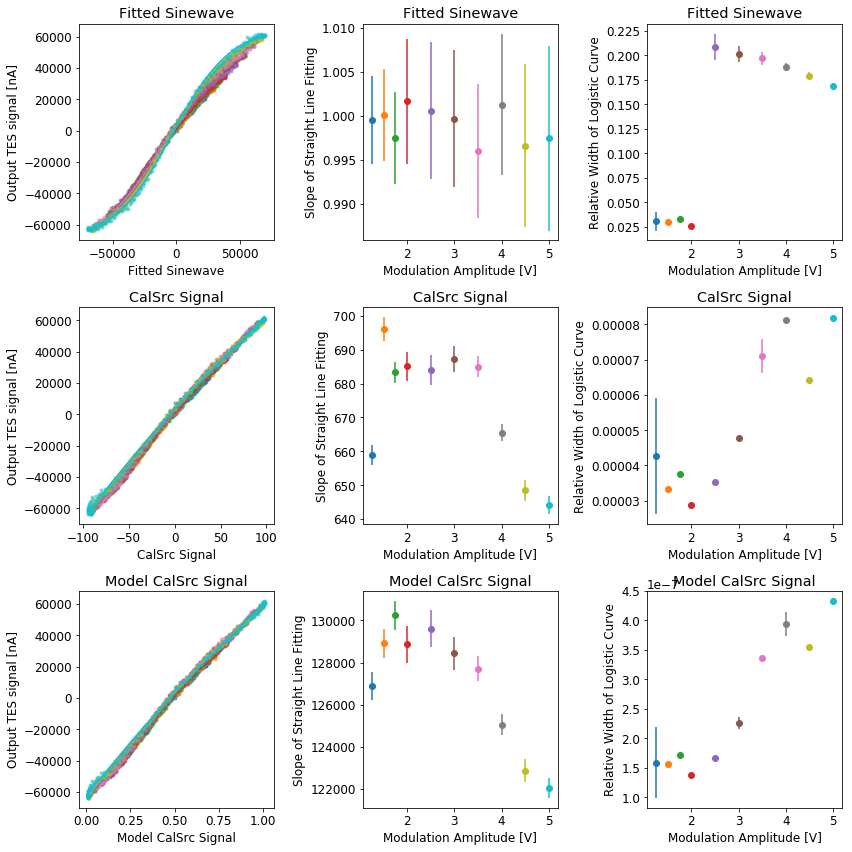

In [215]:
### rc('figure',figsize=(12,12))

for ii in xrange(len(tt)):
    for im in xrange(len(methods)):
        subplot(3,3,3*im+1)
        if methods[im]=='Fitted Sinewave':
            params = allresfit[ii,:]#np.array([amps[ii]/2, 1./modfreqs[ii], allresfit[ii,2], offsets[ii]])
            input_curve = sine(t, params)
        elif methods[im]=='CalSrc Signal':
            input_curve = shift_src(tsrc, allresfit_src[ii,:])/np.abs(allresfit_src[ii,0])
        elif methods[im]=='Model CalSrc Signal':
            input_curve = sinesat(tsrc, allresfit_src_model[ii,:])/np.abs(allresfit_src_model[ii,0])+0.5

        p=plot(input_curve, allfolded[ii,:], '.', alpha=0.5)
        xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
        #plot(xxx, ft.thepolynomial(xxx, allres[:,ii]), color=p[0].get_color())
        plot(xxx, logistic(xxx, allres_logistic[im, :,ii]), color=p[0].get_color())
        xlabel(methods[im])
        ylabel('Output TES signal [nA]')
        title(methods[im])

    
        subplot(3,3,3*im+2)
        errorbar(amps[ii], allres[im, 0,ii], yerr=allerr[im, 0,ii],fmt='o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Slope of Straight Line Fitting')
        title(methods[im])

        subplot(3,3,3*im+3)
        amp_width = allres_logistic[im, 2,ii]/allres_logistic[im, 0,ii]
        err_amp_width = amp_width * ( np.abs(allerr_logistic[im, 0,ii]/allres_logistic[im, 0,ii]) + np.abs(allerr_logistic[im, 2,ii]/allres_logistic[im, 2,ii]))
        errorbar(amps[ii], amp_width, yerr=err_amp_width,fmt='o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Relative Width of Logistic Curve')
        title(methods[im])

tight_layout()